<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 2*

# Sprint Challenge - Neural Network Foundations

Table of Problems

1. [Defining Neural Networks](#Q1)
2. [Chocolate Gummy Bears](#Q2)
    - Perceptron
    - Multilayer Perceptron
4. [Keras MMP](#Q3)

<a id="Q1"></a>
## 1. Define the following terms:

- **Neuron:**
-- a perceptron that takes a weighted sum of inputs, adds bias, as passes through an activation function to determine whether it passes info to the next stage; where output = activation_function(WX + b)
- **Input Layer:**
-- the layer that takes the input neurons/ brings the data into the system
- **Hidden Layer:**
-- the "black box" of the NN, in between the input and output layers, doesn't look outside
- **Output Layer:**
-- the final layer that outputs the numbers/makes inferences
- **Activation:**
-- transforms a matrix into a desirable shape for output. (sigmoid, tanh, step, relu)
- **Backpropagation:**
-- goal is to adjust each weight in the network proportional to how much it contributes to the overall error


## 2. Chocolate Gummy Bears <a id="Q2"></a>

Right now, you're probably thinking, "yuck, who the hell would eat that?". Great question. Your candy company wants to know too. And you thought I was kidding about the [Chocolate Gummy Bears](https://nuts.com/chocolatessweets/gummies/gummy-bears/milk-gummy-bears.html?utm_source=google&utm_medium=cpc&adpos=1o1&gclid=Cj0KCQjwrfvsBRD7ARIsAKuDvMOZrysDku3jGuWaDqf9TrV3x5JLXt1eqnVhN0KM6fMcbA1nod3h8AwaAvWwEALw_wcB). 

Let's assume that a candy company has gone out and collected information on the types of Halloween candy kids ate. Our candy company wants to predict the eating behavior of witches, warlocks, and ghosts -- aka costumed kids. They shared a sample dataset with us. Each row represents a piece of candy that a costumed child was presented with during "trick" or "treat". We know if the candy was `chocolate` (or not chocolate) or `gummy` (or not gummy). Your goal is to predict if the costumed kid `ate` the piece of candy. 

If both chocolate and gummy equal one, you've got a chocolate gummy bear on your hands!?!?!
![Chocolate Gummy Bear](https://ed910ae2d60f0d25bcb8-80550f96b5feb12604f4f720bfefb46d.ssl.cf1.rackcdn.com/3fb630c04435b7b5-2leZuM7_-zoom.jpg)

In [0]:
from google.colab import files
uploaded = files.upload()

Saving chocolate_gummy_bears.csv to chocolate_gummy_bears (1).csv


In [0]:
import pandas as pd
candy = pd.read_csv('chocolate_gummy_bears.csv')

In [0]:
print(candy.shape)
candy.head()

(10000, 3)


,chocolate,gummy,ate
0,0,1,1
1,1,0,1
2,0,1,1
3,0,0,0
4,1,1,0


### Perceptron

To make predictions on the `candy` dataframe. Build and train a Perceptron using numpy. Your target column is `ate` and your features: `chocolate` and `gummy`. Do not do any feature engineering. :P

Once you've trained your model, report your accuracy. Explain why you could not achieve a higher accuracy with a *simple perceptron*. It's possible to achieve ~95% accuracy on this dataset.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline
np.random.seed(42)

In [0]:
# Start your candy perceptron here

X = candy[['chocolate', 'gummy']].values
y = candy['ate'].values

In [0]:
class Perceptron():
    def __init__(self, inputs=2, output=1, rate=0.01, n_iter=100):
        self.input = inputs
        self.output = output
        self.rate = rate
        self.n_iter = n_iter
        
        # Initialize random weights
        self.weight = np.random.randn(inputs, output)
        
        # Initialize bias
        self.bias = np.zeros(output)
        
        # Initialize loss function (empty list for empty perceptron)
        self.loss = []
        pass
    
    # Define sigmoid function
    def sigmoid(self, x):
        """
        Sigmoid function
        """
        return 1 / (1 + np.exp(-x))
    
    # Sigmoid derivative function
    def sigmoid_derivative(self, x):
        """
        Sigmoid derivative
        """
        sx = self.sigmoid(x)
        return sx * (1-sx)
    
    # Define neural network affine function
    def affine_func(self, x, w, b):
        '''
        y = Wx + b
        '''
        scores = x.dot(w) + b
        cache = (x, w, b)
        return scores, cache
    
    # Define back-propagation
    def back_prop(self, d_out, cache):
        '''
        dY
        '''
        x, w, b = cache
        dx = d_out.dot(w.T)
        dw = x.reshape(-1, 1).dot(d_out.reshape(-1, 1))
        db = np.sum(d_out, axis=0)
        
        return dx, dw, db
    
    def fit(self, x, y):
        '''
        Fit the perceptron
        '''
        for i in range(self.n_iter):            
            for j in range(x.shape[0]):
                # forward prop
                scores, cache = self.affine_func(x[j], self.weight, self.bias)
                
                # scoring
                out = self.sigmoid(scores)
                loss = y[j] - out.reshape(-1,)
                self.loss.append(loss)
                
                # back prop
                dout = loss * self.sigmoid_derivative(out)
                _, dw, db = self.back_prop(dout.reshape(-1,), cache)
        
                # gradient update
                self.weight += dw
                self.bias += db
        pass
        
    def predict(self, x):
        '''
        Make predictions
        '''
        return self.sigmoid(self.affine_func(x, self.weight, self.bias)[0])

In [0]:
choco_gum = Perceptron(inputs=2, output=1)
choco_gum.fit(X, y)

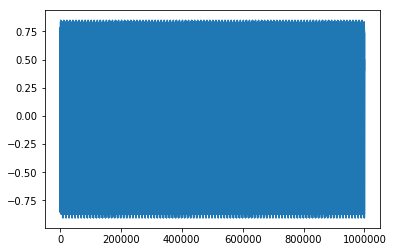

In [0]:
# Plot loss
plt.plot(choco_gum.loss);

In [0]:
# Score accuracy of model
test1 = np.array([0, 0])
test2 = np.array([0, 1])
test3 = np.array([1, 0])
test4 = np.array([1, 1])
print("{}".format(test1), choco_gum.predict(test1))
print("{}".format(test2), choco_gum.predict(test2))
print("{}".format(test3), choco_gum.predict(test3))
print("{}".format(test4), choco_gum.predict(test4))

[0 0] [0.62055029]
[0 1] [0.74881462]
[1 0] [0.63797195]
[1 1] [0.7626002]


In [0]:
y_pred = choco_gum.predict(X)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(f'accuracy is {accuracy_score(y, y_pred.reshape(-1,))}')

accuracy is 0.5


In [0]:
'''
There is only so much we can do with a simple perceptron because of it's
linear limitations (i.e. y = mx + b, or in this instance a = wX + b). There is
only a binary linear relationship between the inputs and outputs. Thus, there is
only so much we are able to achieve with a singular perceptron.
'''

"\nThere is only so much we can do with a simple perceptron because of it's\nlinear limitations (i.e. y = mx + b, or in this instance a = wX + b). There is\nonly a binary linear relationship between the inputs and outputs. Thus, there is\nonly so much we are able to achieve with a singular perceptron.\n"

### Multilayer Perceptron <a id="Q3"></a>

Using the sample candy dataset, implement a Neural Network Multilayer Perceptron class that uses backpropagation to update the network's weights. Your Multilayer Perceptron should be implemented in Numpy. 
Your network must have one hidden layer.

Once you've trained your model, report your accuracy. Explain why your MLP's performance is considerably better than your simple perceptron's on the candy dataset. 

In [0]:
# Create Perceptron class that has input, hidden, and output layers
class SkyNet(object):
    def __init__(self, inputs=2, hidden=3, output=1, n_iter=1000):
        self.n_iter = n_iter
        
        # Initialize random weights
        self.weight1 = np.random.rand(inputs, hidden) / np.sqrt(inputs)
        self.weight2 = np.random.rand(hidden, output) / np.sqrt(hidden)
        
        # Initialize bias
        self.bias1 = np.zeros(hidden)
        self.bias2 = np.zeros(output)
        
        # Initialize loss function list
        self.loss = []
    
    # Define sigmoid function
    def sigmoid(self, x):
        """
        Sigmoid function
        """
        return 1 / (1 + np.exp(-x))
    
    # Sigmoid derivative function
    def sigmoid_derivative(self, x):
        """
        Sigmoid derivative
        """
        sx = self.sigmoid(x)
        return sx * (1-sx)
    
    # Define neural network affine function
    def affine_func(self, x, w, b):
        '''
        y = Wx + b
        '''
        scores = x.dot(w) + b
        cache = (x, w, b)
        return scores, cache
    
    # Define back-propagation (affine backwards - not actual backpropagation)
    def back_prop(self, d_out, cache):
        '''
        dY
        '''
        x, w, b = cache
        dx = d_out.dot(w.T).reshape(x.shape) # reshaping for useability
        dw = x.T.dot(d_out)
        db = np.sum(d_out, axis=0)
        
        return dx, dw, db
    
    def fit(self, x, y):
        '''
        Fit the network
        '''
        for i in range(self.n_iter):           
            # forward prop
            a1, cache_l1 = self.affine_func(x, self.weight1, self.bias1)
            out_l1 = self.sigmoid(a1)
            a2, cache_l2 = self.affine_func(out_l1, self.weight2, self.bias2)

            # scoring
            out_l2 = self.sigmoid(a2)
            loss = y.reshape(-1, 1) - out_l2
            self.loss.append(loss[0][0])

            # back prop
            da2 = loss * self.sigmoid_derivative(out_l2)
            dout_l2, dW2, db2 = self.back_prop(da2, cache_l2)
            da1 = dout_l2 * self.sigmoid_derivative(out_l1)
            _, dW1, db1 = self.back_prop(da1, cache_l1)

            # gradient update
            self.weight1 += dW1
            self.bias1 += db1
            self.weight2 += dW2
            self.bias2 += db2
        
    def predict(self, x):
        '''
        Make predictions
        '''
        x = np.array(x)
        a1, _ = self.affine_func(x, self.weight1, self.bias1)
        out1 = self.sigmoid(a1)
        scores = self.affine_func(out1, self.weight2, self.bias2)
        out = self.sigmoid(scores[0])
        return out

In [0]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(candy.iloc[:, :-1].values, 
                                                    candy.iloc[:, -1].values, 
                                                    test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 2), (2000, 2), (8000,), (2000,))

In [0]:
nn = SkyNet(inputs=2, hidden=3, output=1, n_iter=100)
nn.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


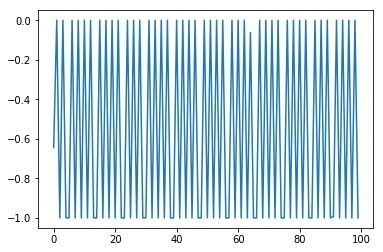

In [0]:
plt.plot(nn.loss);

In [0]:
y_pred = nn.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(f'accuracy is {accuracy_score(y_test, y_pred.reshape(-1,))}')

accuracy is 0.506


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


In [0]:
'''
Multilayer are able to identify non-linear relationships, which makes them
much more durable than a singular perceptron.
'''

'\nMultilayer are able to identify non-linear relationships, which makes them\nmuch more durable than a singular perceptron.\n'

P.S. Don't try candy gummy bears. They're disgusting. 

## 3. Keras MMP <a id="Q3"></a>

Implement a Multilayer Perceptron architecture of your choosing using the Keras library. Train your model and report its baseline accuracy. Then hyperparameter tune at least two parameters and report your model's accuracy.
Use the Heart Disease Dataset (binary classification)
Use an appropriate loss function for a binary classification task
Use an appropriate activation function on the final layer of your network.
Train your model using verbose output for ease of grading.
Use GridSearchCV or RandomSearchCV to hyperparameter tune your model. (for at least two hyperparameters)
When hyperparameter tuning, show you work by adding code cells for each new experiment.
Report the accuracy for each combination of hyperparameters as you test them so that we can easily see which resulted in the highest accuracy.
You must hyperparameter tune at least 3 parameters in order to get a 3 on this section.

In [0]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv')
df = df.sample(frac=1)
print(df.shape)
df.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
44,39,1,2,140,321,0,0,182,0,0.0,2,0,2,1
175,40,1,0,110,167,0,0,114,1,2.0,1,0,3,0
81,45,1,1,128,308,0,0,170,0,0.0,2,0,2,1
172,58,1,1,120,284,0,0,160,0,1.8,1,0,2,0
144,76,0,2,140,197,0,2,116,0,1.1,1,0,2,1


In [0]:
x = df.values 
min_max_scaler = StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x_scaled[:, :-1], 
                                                    x_scaled[:, -1], 
                                                    test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(242, 13) (61, 13) (242,) (61,)


In [0]:
from tensorflow.keras.layers import BatchNormalization

# Instantiate the model
model = Sequential()

# Add layers to the model (1 hidden layer as base model)

# Input -> Hidden
model.add(Dense(64, input_dim=13, activation='relu'))
model.add(BatchNormalization())

# Hidden
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

# Hidden -> Output
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Fit model
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=100, batch_size=50)

# Inspect architecture
model.summary()

Train on 193 samples, validate on 49 samples
Epoch 1/100
193/193 [==============================] - 1s 5ms/sample - loss: 0.1696 - acc: 0.0000e+00 - val_loss: 0.4243 - val_acc: 0.0000e+00
Epoch 2/100
193/193 [==============================] - 0s 96us/sample - loss: -0.2961 - acc: 0.0000e+00 - val_loss: 0.3297 - val_acc: 0.0000e+00
Epoch 3/100
193/193 [==============================] - 0s 76us/sample - loss: -0.6814 - acc: 0.0000e+00 - val_loss: 0.2361 - val_acc: 0.0000e+00
Epoch 4/100
193/193 [==============================] - 0s 80us/sample - loss: -0.9599 - acc: 0.0000e+00 - val_loss: 0.1446 - val_acc: 0.0000e+00
Epoch 5/100
193/193 [==============================] - 0s 97us/sample - loss: -1.2166 - acc: 0.0000e+00 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 6/100
193/193 [==============================] - 0s 80us/sample - loss: -1.4937 - acc: 0.0000e+00 - val_loss: -0.0314 - val_acc: 0.0000e+00
Epoch 7/100
193/193 [==============================] - 0s 89us/sample - loss: -1.7347 

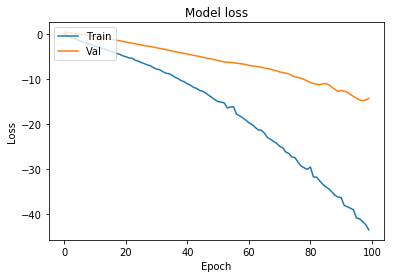

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

In [0]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy is {scores[1]}")

Test accuracy is 0.0


In [0]:
# GridSearch for accuracy
inputs = X_train.shape[1]

def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(inputs,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {'batch_size': [16, 32, 64],
              'epochs': [20, 80]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Best: 0.8305785195393995 using {'batch_size': 64, 'epochs': 20}
Means: 0.8223140402273699, Stdev: 0.01647397783782909 with: {'batch_size': 16, 'epochs': 20}
Means: 0.8181818098076119, Stdev: 0.006438149940411827 with: {'batch_size': 16, 'epochs': 80}
Means: 0.8305785165837973, Stdev: 0.023864639399659326 with: {'batch_size': 32, 'epochs': 20}
Means: 0.8305785151059962, Stdev: 0.025555007069023375 with: {'batch_size': 32, 'epochs': 80}
Means: 0.8305785195393995, Stdev: 0.04283336474787829 with: {'batch_size': 64, 'epochs': 20}
Means: 0.818181831235728, Stdev: 0.023903363515775548 with: {'batch_size': 64, 'epochs': 80}


In [0]:
print(f'{grid_result.best_params_} {grid_result.best_score_}')

{'batch_size': 64, 'epochs': 20} 0.8305785195393995
